# Portfolio Simulation
This notebook contains an analysis on different strategies for a portfolio. It performs a Montecarlo simulation with Bootstrap to figure out the expected return in various scenarios, expected DrawDown, volatility, and 5% percentile worst scenarios

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import os

In [ ]:
def montecarlo_bootstrap_monthly(returns_df, n_simulations=1000, horizon=60):
    """
    returns_df: DataFrame con rendimenti mensili (righe = mesi, colonne = asset)
    n_simulations: numero di simulazioni Monte Carlo
    horizon: orizzonte in mesi da simulare (es. 60 mesi = 5 anni)
    """
    asset_names = returns_df.columns

    # Matrice di correlazione e decomposizione di Cholesky
    correlation_matrix = returns_df.corr().values
    chol = np.linalg.cholesky(correlation_matrix)

    simulations = []

    for _ in range(n_simulations):
        # 1. Bootstrap dei rendimenti: righe con rimpiazzo (random pick)
        sampled = returns_df.sample(n=horizon, replace=True).values.T  # shape (n_assets, horizon)

        # 2. Applica correlazione
        correlated = chol @ sampled  # shape (n_assets, horizon)

        # 3. Ritorna in forma di DataFrame
        sim_df = pd.DataFrame(correlated.T, columns=asset_names)
        simulations.append(sim_df)

    return simulations  # lista di DataFrame (uno per simulazione)

def load_log_return_series_from_csv(filepath, asset_name):
    df = pd.read_csv(filepath, parse_dates=["date"])
    df = df.sort_values("date").set_index("date")

    # filter for dates after 1998-12-01
    df = df[df.index > "1998-12-01"]

    # Calcola log-returns: ln(Pt / Pt-1)
    df["log_return"] = np.log(df["value"] / df["value"].shift(1))
    df = df[["log_return"]].dropna()
    df.columns = [asset_name]

    return df


def create_simulations(all_dfs, store = False):
    returns_df = pd.concat([df["df"] for df in all_dfs], axis=1).dropna()

    simulations = {}

    for horizon in [60, 120, 180, 240]:
        print(f"Simulazioni per orizzonte di {horizon} mesi:")
        sims = montecarlo_bootstrap_monthly(returns_df, n_simulations=10000, horizon=horizon)
        simulations[horizon] = sims
        print(f"Numero di simulazioni: {len(sims)}\n")
        if store:
            # Salva le simulazioni in un file CSV
            output_dir = f"data/simulations/horizon_{horizon}"
            os.makedirs(output_dir, exist_ok=True)
            for i, sim in enumerate(sims):
                sim.to_csv(os.path.join(output_dir, f"simulation_{i+1}.csv"), index=True)

    return simulations


all_dfs = [{"name": f.replace(".csv",""), "df": load_log_return_series_from_csv(os.path.join("data/csv", f), f.replace(".csv",""))} for f in os.listdir("data/csv") if f.endswith('.csv')]

montecarlo_simulations = create_simulations(all_dfs)


In [ ]:
# create a copy of the simulations for portfolio analysis
portfolios_weights = [
    {"name": "60-40", "composition": [("msci-world", 0.6), ("bond-7-10", 0.4)]},
    {"name": "All-Weather World", "composition": [("msci-world", 0.5), ("bond-7-10", 0.3), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1)]},
    {"name": "Factors + Cash", "composition": [("msci-world-momentum", 0.35),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]}
]
#portfolio_simulations = {horizon: [sim.copy() for sim in montecarlo_simulations[horizon]] for horizon in montecarlo_simulations}
portfolio_simulations = {horizon: [pd.DataFrame() for _ in range(len(montecarlo_simulations[horizon]))] for horizon in montecarlo_simulations}
for horizon in montecarlo_simulations:
    # build different portfolios, e.g., equal weight, market cap weight, etc.
    for i, sim in enumerate(montecarlo_simulations[horizon]):
        for weight in portfolios_weights:
            # create a portfolio based on the weights
            portfolio_sim = sum(sim[asset[0]] * weight['composition'][j][1] for j, asset in enumerate(weight['composition']))
            # set the name of the portfolio
            portfolio_sim.name = f"{weight['name']}_Portfolio_{i+1}_Horizon_{horizon}"
            portfolio_simulations[horizon][i][weight['name']] = portfolio_sim

        # # Example: equal weight portfolio
        # portfolio_sim = sim.mean(axis=1)
        # # set the name of the portfolio
        # portfolio_sim.name = f"Portfolio_{i+1}_Horizon_{horizon}"
        # portfolio_simulations[horizon][i]['equal-weighted'] = portfolio_sim

In [ ]:
# for each simulation, calculate the mean and standard deviation of the returns
def calculate_simulation_stats(simulations):
    stats = {}
    for horizon, sim_list in simulations.items():
        mean_returns = []
        std_returns = []
        for sim in sim_list:
            mean_returns.append(sim.mean())
            std_returns.append(sim.std())
        stats[horizon] = {
            "mean": pd.DataFrame(mean_returns).mean(),
            "std": pd.DataFrame(std_returns).mean()
        }
    return stats

simulation_stats = calculate_simulation_stats(montecarlo_simulations)
simulation_stats

In [4]:
# for each simulation calculate the cumulative returns
def calculate_cumulative_returns(simulations):
    cumulative_returns = {}
    for horizon, sim_list in simulations.items():
        cum_returns = []
        for sim in sim_list:
            cum_return = (1 + sim).cumprod() - 1  # Calcola i rendimenti cumulativi
            cum_returns.append(cum_return)
        cumulative_returns[horizon] = cum_returns
    return cumulative_returns

def analyze_simulations(simulations):
    final_returns_list = []
    variances_list = []

    for sim in simulations:
        # Calcolo del rendimento cumulativo per ogni asset (log → somma, altrimenti moltiplica)
        cumulative = (1 + sim).sum() - 1  # se usi pct_change; usa .sum() se hai log-returns
        variance = sim.std()  # varianza su tutti i mesi

        final_returns_list.append(cumulative)
        variances_list.append(variance)

    # Combina i risultati in DataFrame
    final_returns_df = pd.DataFrame(final_returns_list)
    variances_df = pd.DataFrame(variances_list)

    # Rendimento medio finale e varianza media su tutte le simulazioni
    mean_final_return = final_returns_df.mean()
    mean_variance = variances_df.mean()

    return mean_final_return, mean_variance

def max_drawdown(rets_df, initial_value=100):
    # 1. Calcola indice di ricchezza cumulato (wealth index)
    wealth = (1 + rets_df).cumprod() * initial_value

    # 2. Calcola picco cumulativo (running max)
    running_max = wealth.cummax()

    # 3. Calcola drawdown in ogni istante
    drawdown = wealth / running_max - 1

    # 4. Massimo drawdown (più negativo) per asset
    mdd = drawdown.min()

    return mdd


def summarize_simulations(simulations, months, use_log_returns=False):
    final_returns = []
    variances = []
    max_drawdowns = []

    for sim in simulations:
        if use_log_returns:
            cumulative_return = np.exp(sim.sum()) - 1
        else:
            cumulative_return = (1 + sim).prod() - 1

        variance = sim.std()

        ## annualizza il rendimento cumulativo e la varianza
        cumulative_return_annualized = (1 + cumulative_return) ** (12 / months) - 1
        variance_annualized = variance * np.sqrt(12)
        mdd = max_drawdown(sim)

        final_returns.append(cumulative_return_annualized)
        variances.append(variance_annualized)
        max_drawdowns.append(mdd)

    # Costruisci i DataFrame
    final_returns_df = pd.DataFrame(final_returns)    # ogni riga = 1 simulazione
    variances_df = pd.DataFrame(variances)
    max_drawdowns_df = pd.DataFrame(max_drawdowns)

    return final_returns_df, variances_df, max_drawdowns_df

def horizon_summary(montecarlo_simulations, horizon, use_log_returns=False):
    ret_df, var_df, mdd_df = summarize_simulations(montecarlo_simulations[horizon], horizon, use_log_returns=use_log_returns)

    # Calcola il ritorno finale sapendo che red_df contiene il ritorno annualizzato, quindi elevato a 12/horizon
    final_df = (1 + ret_df) ** (horizon / 12) - 1


    # Analisi per asset
    summary = pd.DataFrame({
        "mean_return": ret_df.mean(),
        "5th_percentile_return": ret_df.quantile(0.05),
        "worst_return": ret_df.min(),
        "horizon_mean_return": final_df.mean(),
        "horizon_5th_percentile_return": final_df.quantile(0.05),
        "mean_variance": var_df.mean(),
        "expected_mdd": mdd_df.mean(),
        "max_dd": mdd_df.quantile(0.05),
    })

    return summary

import matplotlib.pyplot as plt

def save_describe_as_image(df, title, filename="describe_output.png"):
    desc = df

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axis('off')  # nasconde gli assi
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    table = ax.table(
        cellText=desc.values,
        colLabels=desc.columns,
        rowLabels=desc.index,
        loc='center',
        cellLoc='center'
    )
    table.scale(1, 1.5)  # opzionale: regola dimensione
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()


# for months in [60, 120, 180, 240]:
#     summ = horizon_summary(montecarlo_simulations, months, use_log_returns=True)
#     save_describe_as_image(summ, f"Summary for {months} months", filename=f"summary_{months}_months.png")
#     print(f"Summary for {months} months:\n", summ)
months = 240
summ = horizon_summary(portfolio_simulations, months, use_log_returns= False)
summ

NameError: name 'portfolio_simulations' is not defined

In [ ]:
summ_mc = horizon_summary(montecarlo_simulations, months, use_log_returns= False)
summ_mc

# PORTFOLIO SIMULATION - MONTECARLO WITH MEAN AND STD

In [20]:
# given the mean and the std of a normal distribution, calculate montecarlo simulations for horizons 60,120,180,240, and return a DataFrame with the data
def generate_montecarlo_from_normal(mean, std, n_simulations=1000):
    # rendimento mensilizzato
    mean = (1 + mean) ** (1/12) - 1  # convert annual to monthly
    std = std / np.sqrt(12)  # convert annual std to monthly std
    horizons = [60, 120, 180, 240, 360]
    results = {horizon: [] for horizon in horizons}

    for horizon in horizons:
        # Simula i rendimenti per ogni orizzonte temporale e crea un dataframe per ogni simulazione
        for _ in range(n_simulations):
            # Genera rendimenti normali per l'orizzonte specificato
            simulated_returns = np.random.normal(loc=mean, scale=std, size=horizon)
            # Calcola il rendimento cumulativo
            results[horizon].append(pd.DataFrame(simulated_returns))

    return results

normal_portfolios = generate_montecarlo_from_normal(0.0848, 0.0898, n_simulations=10000)


In [21]:
def horizon_summary(montecarlo_simulations, horizon_list=[60, 120, 180, 240, 360], use_log_returns=False):
    rows = []

    for horizon in horizon_list:
        ret_df, var_df, mdd_df = summarize_simulations(montecarlo_simulations[horizon], horizon, use_log_returns=use_log_returns)

        # Calcola il ritorno finale
        final_df = (1 + ret_df) ** (horizon / 12) - 1

        for sigma in [0.025, 0.15, 0.5, 0.7, 0.95]:
            # find the index of the simulation that corresponds to the sigma quantile
            # Calcola il quantile su ret_df
            quantile_value = ret_df.quantile(sigma).item()  # ottieni lo scalare

            # Trova l'indice della riga più vicina
            closest_index = (ret_df.iloc[:, 0] - quantile_value).abs().idxmin()


            # usa questo indice per ottenere i dati di final, variance e mdd


            summary = {
                "horizon_sigma": f"{horizon}_{sigma}",
                "return": ret_df.loc[closest_index].item(),
                "final": final_df.loc[closest_index].item(),
                "variance": var_df.loc[closest_index].item(),
                "mdd": mdd_df.loc[closest_index].item()
            }

            rows.append(summary)

    # Crea il DataFrame finale
    tot_summary = pd.DataFrame(rows).set_index("horizon_sigma")

    return tot_summary

summ_normal = horizon_summary(normal_portfolios, use_log_returns= False)
summ_normal

,return,final,variance,mdd
horizon_sigma,,,,
60_0.025,-0.000448,-0.002237,0.086242,-0.183366
60_0.15,0.037637,0.202897,0.089289,-0.113900
60_0.5,0.080466,0.472502,0.084096,-0.108896
60_0.7,0.103122,0.633494,0.107099,-0.094159
60_0.95,0.154555,1.051509,0.088392,-0.086488
120_0.025,0.021567,0.237855,0.089600,-0.180642
120_0.15,0.049201,0.616537,0.078651,-0.138798
120_0.5,0.079902,1.156968,0.091418,-0.149753
120_0.7,0.096423,1.510632,0.089547,-0.127601


# Portfolio Simulation - Montecarlo WITH Bootstrap

In [124]:
portfolios_weights = [
    {"name": "MSCI-World", "composition": [("msci-world", 1)]},
    {"name": "60-40", "composition": [("msci-world", 0.6), ("bond-7-10", 0.4)]},
    {"name": "All-Weather World", "composition": [("msci-world", 0.6), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1)]},
    {"name": "Factors - No Bond", "composition": [("msci-world-momentum", 0.45),("msci-world-min-vol", 0.35), ("gold", 0.1), ("cash", 0.1)]},
    {"name": "Factors + Cash", "composition": [("msci-world-momentum", 0.35),("msci-world-min-vol", 0.25), ("bond-7-10", 0.2), ("gold", 0.1), ("cash", 0.1)]}
]
import pandas as pd
import os
from functools import reduce

def load_asset_data(assets, path="data/csv"):
    asset_data = {}
    for asset in assets:
        file_path = os.path.join(path, f"{asset}.csv")
        df = pd.read_csv(file_path, parse_dates=True, index_col=0)
        df = df.sort_index()
        df = df[df.columns[0]]
        asset_data[asset] = df.rename(asset)
    return asset_data

def align_assets(asset_data):
    return reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how="inner"),
                  asset_data.values())

def compute_monthly_returns(prices_df, log_returns=False):
    if log_returns:
        return np.log(prices_df / prices_df.shift(1)).dropna()
    else:
        return prices_df.pct_change().dropna()


def construct_portfolios(portfolios, asset_returns):
    portfolio_returns = {}

    for portfolio in portfolios:
        name = portfolio["name"]
        composition = portfolio["composition"]

        weights = {asset: weight for asset, weight in composition}

        # check if the sum of the weights is 1
        if not np.isclose(sum(weights.values()), 1.0):
            raise ValueError(f"Weights for portfolio '{name}' do not sum to 1.0")

        df = pd.DataFrame()
        for asset, weight in weights.items():
            df[asset] = asset_returns[asset] * weight

        portfolio_returns[name] = df.sum(axis=1)

    return pd.DataFrame(portfolio_returns)

def prepare_portfolios(portfolios_weights, data_path="data/csv", log_returns=False):
    all_assets = sorted(set(asset for p in portfolios_weights for asset, _ in p["composition"]))
    asset_data = load_asset_data(all_assets, path=data_path)
    aligned_prices = align_assets(asset_data)
    aligned_returns = compute_monthly_returns(aligned_prices, log_returns=log_returns)
    portfolio_returns = construct_portfolios(portfolios_weights, aligned_returns)
    return portfolio_returns, aligned_returns

portfolio_returns, asset_returns = prepare_portfolios(portfolios_weights)


In [125]:
def portfolio_statistics(returns, periods_per_year=12):
    stats = pd.DataFrame(index=returns.columns)

    # 1. Rendimento annualizzato (media geometrica)
    stats["annualized_return"] = (1 + returns.mean()) ** periods_per_year - 1

    # 2. Volatilità annualizzata
    stats["annualized_volatility"] = returns.std() * np.sqrt(periods_per_year)

    # 3. Maximum Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = cum_returns / peak - 1
    stats["max_drawdown"] = drawdown.min()

    return stats
portfolio_stats = portfolio_statistics(portfolio_returns)
print(portfolio_stats)




                   annualized_return  annualized_volatility  max_drawdown
MSCI-World                  0.092772               0.138525     -0.487969
60-40                       0.069769               0.088298     -0.279779
All-Weather World           0.074850               0.085135     -0.266294
Factors                     0.090735               0.090399     -0.275959
Factors - No Bond           0.092560               0.097943     -0.325160
Factors + Cash              0.079871               0.077232     -0.226424


In [126]:
def montecarlo_bootstrap(returns, n_simulations=1000, horizon_months=120, log_returns=False, seed=None):
    """
    Simula traiettorie future con bootstrap dei rendimenti storici.
    
    returns: Series (es. un portafoglio)
    log_returns: True = usa somma log, False = usa compounding semplice
    """
    if seed:
        np.random.seed(seed)
        
    returns = returns.dropna().values
    n_obs = len(returns)

    simulations = []

    for _ in range(n_simulations):
        sampled = np.random.choice(returns, size=horizon_months, replace=True)
        
        if log_returns:
            cumulative = np.exp(np.cumsum(sampled))  # da log-rendimenti a valore relativo
        else:
            cumulative = np.cumprod(1 + sampled)

        simulations.append(cumulative)

    return pd.DataFrame(simulations).T  # colonne = simulazioni, righe = mesi

def run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], 
                                   n_simulations=1000, log_returns=False):
    simulations = {}

    for portfolio in portfolio_returns.columns:
        portfolio_simulations = {}
        for h in horizons:
            sim_df = montecarlo_bootstrap(portfolio_returns[portfolio], horizon_months=h,
                                          n_simulations=n_simulations, log_returns=log_returns)
            portfolio_simulations[h] = sim_df
        simulations[portfolio] = portfolio_simulations

    return simulations

simulations = run_montecarlo_for_portfolios(portfolio_returns, horizons=[60, 120, 180, 240, 360], n_simulations=1000)


In [138]:
def calc_max_recovery_time(series):
    peak = series.cummax()
    in_drawdown = series < peak

    recovery_times = []
    count = 0
    for down in in_drawdown:
        if down:
            count += 1
        else:
            if count > 0:
                recovery_times.append(count)
            count = 0
    if count > 0:
        recovery_times.append(count)

    return max(recovery_times) if recovery_times else 0


def summarize_simulations(sim_df, horizon_months):
    """
    sim_df: DataFrame con simulazioni (righe = mesi, colonne = simulazioni)
    """
    final_vals = sim_df.iloc[-1]
    ann_returns = final_vals ** (12 / horizon_months) - 1

    stats = {}

    for q in ["mean", 0.0, 0.025]:
        if q == "mean":
            col = ann_returns.mean()
            # prendi la colonna più vicina alla media
            sim_id = (ann_returns - col).abs().idxmin()
        else:
            target = ann_returns.quantile(q)
            sim_id = (ann_returns - target).abs().idxmin()

        sim = sim_df[sim_id]

        # Ritorno annualizzato (già calcolato sopra)
        final_val = sim.iloc[-1]
        ann_return = final_val ** (12 / horizon_months) - 1

        # Std annualizzata
        monthly_ret = sim.pct_change().dropna()
        ann_std = monthly_ret.std() * np.sqrt(12)

        # Maximum Drawdown
        cum = sim
        peak = cum.cummax()
        dd = (cum / peak - 1).min()

        recovery_times = [calc_max_recovery_time(sim_df[col]) for col in sim_df.columns]
        # compute the mean of the recovery times
        recovery_time = np.mean(recovery_times) if q == "mean" else calc_max_recovery_time(sim)

        stats[str(q)] = {
            "return": ann_return,
            "std": ann_std,
            "mdd": dd,
            "recovery_time": recovery_time
        }
    # compute the 0.05 quantile of the MDD
    all_mdds = []

    for col in sim_df.columns:
        sim = sim_df[col]
        peak = sim.cummax()
        dd = (sim / peak - 1).min()
        all_mdds.append(dd)

    stats["max_mdd_0.05"] = {
        "return": np.nan,
        "std": np.nan,
        "mdd": pd.Series(all_mdds).quantile(0.0)
    }


    return pd.DataFrame(stats).T

def summarize_all(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            stats_df["portfolio"] = portfolio
            stats_df["horizon"] = h
            stats_df["quantile"] = stats_df.index
            records.append(stats_df.reset_index(drop=True))

    return pd.concat(records).set_index(["portfolio", "horizon", "quantile"])

def summarize_all_wide(simulations):
    records = []

    for portfolio, horizons in simulations.items():
        for h, sim_df in horizons.items():
            stats_df = summarize_simulations(sim_df, horizon_months=h)
            # stats_df ha indice quantile e colonne return,std,mdd

            # Costruiamo un dict che concatena le colonne con quantile nel nome
            flat_dict = {}
            for quantile in stats_df.index:
                for metric in stats_df.columns:
                    flat_dict[f"{metric}_{quantile}"] = stats_df.loc[quantile, metric]

            flat_dict["portfolio"] = portfolio
            flat_dict["horizon"] = h

            records.append(flat_dict)

    return pd.DataFrame(records).set_index(["portfolio", "horizon"])


summary_df = summarize_all_wide(simulations)
summary_df

return_mean  std_mean  mdd_mean  \
portfolio         horizon                                    
MSCI-World        60          0.084466  0.126454 -0.170258   
                  120         0.084653  0.131736 -0.162674   
                  180         0.079921  0.138889 -0.220503   
                  240         0.082962  0.130653 -0.438698   
                  360         0.082990  0.136369 -0.423810   
60-40             60          0.066990  0.085604 -0.089648   
                  120         0.066077  0.085477 -0.100232   
                  180         0.065051  0.077394 -0.102686   
                  240         0.066065  0.082966 -0.109632   
                  360         0.065366  0.089460 -0.180041   
All-Weather World 60          0.071357  0.077105 -0.138008   
                  120         0.073115  0.077312 -0.141541   
                  180         0.072000  0.082476 -0.181907   
                  240         0.070272  0.078007 -0.102850   
                  360         0.071849  0.091066 -0.231407   
Factors           60          0.087379  0.086116 -0.079096   
                  120         0.086878  0.088690 -0.149544   
                  180         0.086764  0.086585 -0.180280   
                  240         0.085900  0.088948 -0.215026   
                  360         0.087867  0.087069 -0.146076   
Factors - No Bond 60          0.086187  0.098535 -0.116469   
                  120         0.088929  0.096029 -0.151806   
                  180         0.086933  0.099177 -0.228774   
                  240         0.088571  0.095675 -0.104714   
                  360         0.088228  0.096852 -0.142104   
Factors + Cash    60          0.077903  0.073218 -0.103022   
                  120         0.078186  0.075560 -0.106301   
                  180         0.076229  0.083001 -0.130778   
                  240         0.075922  0.075691 -0.116899   
                  360         0.077666  0.081559 -0.178576   

                           recovery_time_mean  return_0.0   std_0.0   mdd_0.0  \
portfolio         horizon                                                       
MSCI-World        60                   22.901   -0.099181  0.152084 -0.491875   
                  120                  37.569   -0.056049  0.163211 -0.578143   
                  180                  51.381   -0.071871  0.147135 -0.737944   
                  240                  57.619   -0.031191  0.142689 -0.575780   
                  360                  71.651    0.004819  0.144857 -0.659612   
60-40             60                   19.949   -0.059090  0.117457 -0.331815   
                  120                  31.545   -0.032044  0.100266 -0.442047   
                  180                  40.278   -0.007462  0.098003 -0.220692   
                  240                  46.261    0.008425  0.093475 -0.351391   
                  360                  56.308    0.013998  0.099183 -0.289446   
All-Weather World 60                   18.688   -0.050822  0.105708 -0.326746   
                  120                  27.568   -0.036336  0.097907 -0.310387   
                  180                  34.954   -0.010701  0.094234 -0.356577   
                  240                  41.916   -0.002083  0.090713 -0.398485   
                  360                  47.920    0.022974  0.083794 -0.380028   
Factors           60                   17.453   -0.026915  0.091821 -0.184963   
                  120                  25.734   -0.011361  0.089773 -0.377185   
                  180                  30.611    0.005605  0.088204 -0.182391   
                  240                  35.129    0.015294  0.096508 -0.243836   
                  360                  40.915    0.035790  0.090789 -0.208847   
Factors - No Bond 60                   18.534   -0.058213  0.098970 -0.302100   
                  120                  26.479   -0.004934  0.104607 -0.453054   
                  180                  33.847   -0.005118  0.096860 -0.415881   
                 

In [139]:
summary_60 = summary_df.xs(360, level='horizon')
summary_60

,return_mean,std_mean,mdd_mean,recovery_time_mean,return_0.0,std_0.0,mdd_0.0,recovery_time_0.0,return_0.025,std_0.025,mdd_0.025,recovery_time_0.025,return_max_mdd_0.05,std_max_mdd_0.05,mdd_max_mdd_0.05,recovery_time_max_mdd_0.05
portfolio,,,,,,,,,,,,,,,,
MSCI-World,0.082990,0.136369,-0.423810,71.651,0.004819,0.144857,-0.659612,324.0,0.031168,0.134881,-0.388351,91.0,NaN,NaN,-0.702325,NaN
60-40,0.065366,0.089460,-0.180041,56.308,0.013998,0.099183,-0.289446,119.0,0.034119,0.092781,-0.199703,48.0,NaN,NaN,-0.581669,NaN
All-Weather World,0.071849,0.091066,-0.231407,47.920,0.022974,0.083794,-0.380028,99.0,0.039616,0.087209,-0.168427,62.0,NaN,NaN,-0.380028,NaN
Factors,0.087867,0.087069,-0.146076,40.915,0.035790,0.090789,-0.208847,57.0,0.052472,0.089279,-0.256460,53.0,NaN,NaN,-0.431152,NaN
Factors - No Bond,0.088228,0.096852,-0.142104,45.078,0.026140,0.104322,-0.227455,116.0,0.050890,0.096817,-0.352107,126.0,NaN,NaN,-0.447432,NaN
Factors + Cash,0.077666,0.081559,-0.178576,38.424,0.026703,0.075705,-0.241828,77.0,0.049167,0.079398,-0.179722,81.0,NaN,NaN,-0.339838,NaN


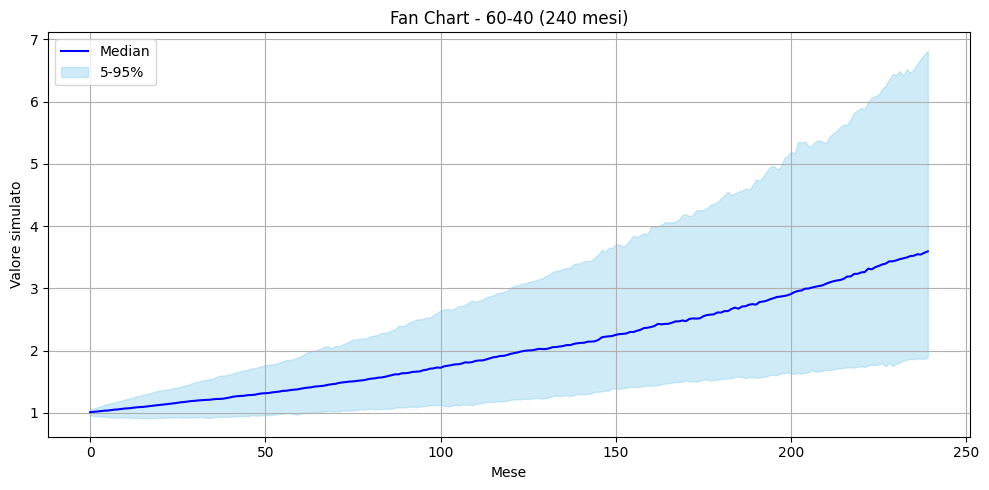

In [140]:
import matplotlib.pyplot as plt

def plot_fan_chart(sim_df, portfolio_name, horizon_months):
    """
    sim_df: una simulazione per un portafoglio e orizzonte
    """
    median = sim_df.median(axis=1)
    q05 = sim_df.quantile(0.05, axis=1)
    q95 = sim_df.quantile(0.95, axis=1)

    plt.figure(figsize=(10, 5))
    plt.plot(median, label="Median", color="blue")
    plt.fill_between(sim_df.index, q05, q95, color="skyblue", alpha=0.4, label="5-95%")

    plt.title(f"Fan Chart - {portfolio_name} ({horizon_months} mesi)")
    plt.xlabel("Mese")
    plt.ylabel("Valore simulato")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_fan_chart(simulations["60-40"][240], "60-40", 240)


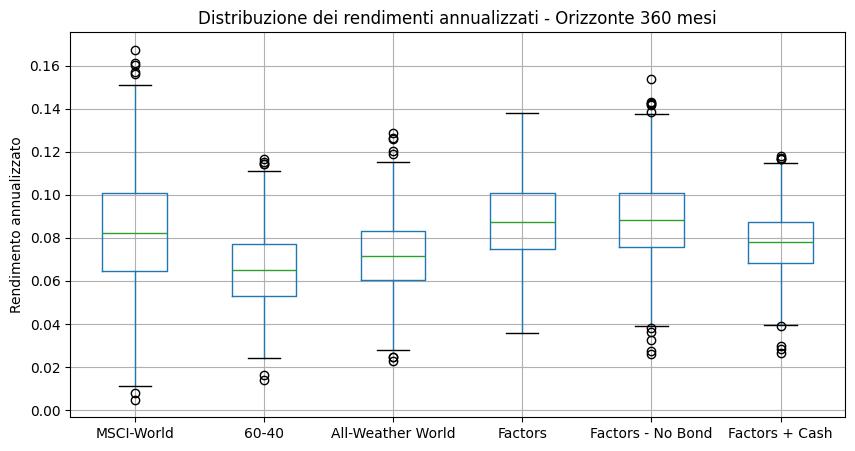

In [141]:
def plot_return_boxplot(simulations, horizon):
    data = {}

    for portfolio in simulations:
        sim_df = simulations[portfolio][horizon]
        final_vals = sim_df.iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        data[portfolio] = ann_ret

    pd.DataFrame(data).boxplot(figsize=(10, 5))
    plt.title(f"Distribuzione dei rendimenti annualizzati - Orizzonte {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.grid(True)
    plt.show()
plot_return_boxplot(simulations, 360)


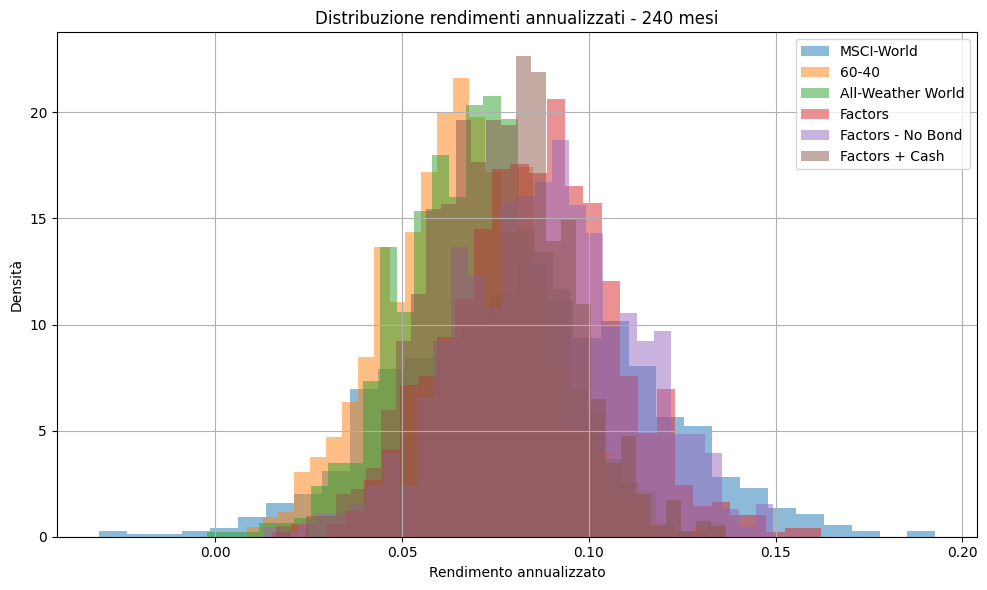

In [142]:
import matplotlib.pyplot as plt

def plot_return_hist(simulations, horizon, bins=30):
    """
    simulations: dict[portfolio][horizon] -> DataFrame simulazioni
    horizon: orizzonte in mesi es. 60
    """
    plt.figure(figsize=(10,6))
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        plt.hist(ann_ret, bins=bins, alpha=0.5, label=portfolio, density=True)

    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.xlabel("Rendimento annualizzato")
    plt.ylabel("Densità")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_return_hist(simulations, horizon=240)


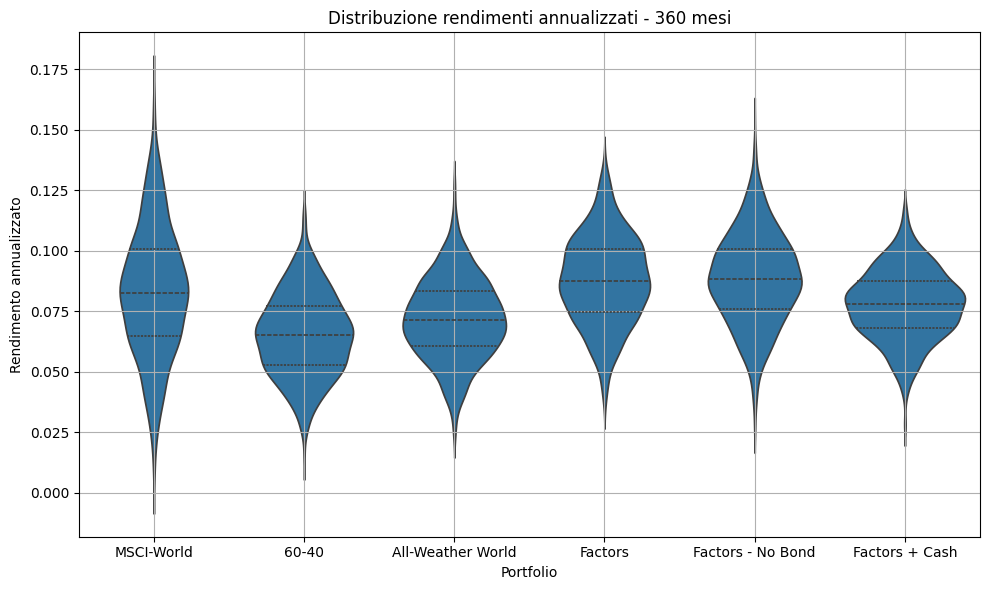

In [144]:
import seaborn as sns

def plot_return_violin(simulations, horizon):
    data = []
    for portfolio, d in simulations.items():
        final_vals = d[horizon].iloc[-1]
        ann_ret = final_vals ** (12 / horizon) - 1
        for val in ann_ret:
            data.append({"portfolio": portfolio, "return": val})
    df = pd.DataFrame(data)

    plt.figure(figsize=(10,6))
    sns.violinplot(x='portfolio', y='return', data=df, inner="quartile")
    plt.title(f"Distribuzione rendimenti annualizzati - {horizon} mesi")
    plt.ylabel("Rendimento annualizzato")
    plt.xlabel("Portfolio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_return_violin(simulations, horizon=360)

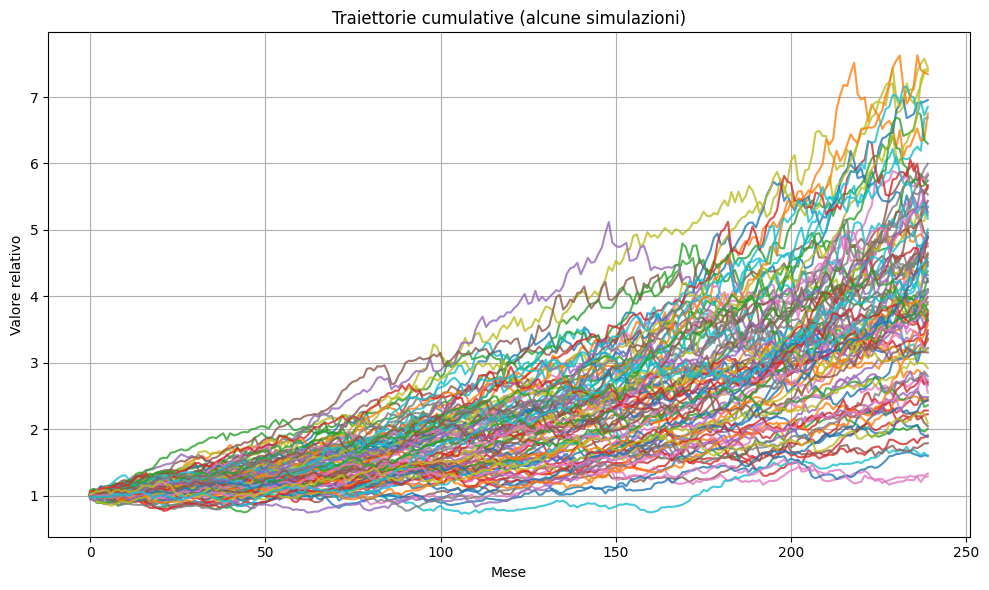

In [148]:
def plot_cumulative_paths(sim_df, num_paths=1000):
    """
    Visualizza num_paths traiettorie casuali su sim_df
    """
    sampled = sim_df.sample(n=min(num_paths, sim_df.shape[1]), axis=1)
    plt.figure(figsize=(10,6))
    for col in sampled:
        plt.plot(sampled[col], alpha=0.8)
    plt.title("Traiettorie cumulative (alcune simulazioni)")
    plt.xlabel("Mese")
    plt.ylabel("Valore relativo")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_cumulative_paths(simulations["60-40"][240], num_paths=100)